In [7]:
import argparse
import logging
import seaborn as sns
import sys
import os
import math
import json
import matplotlib.gridspec as gridspec
from configparser import ConfigParser
import torch
import numpy as np
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from disvae import init_specific_model, Trainer, Evaluator
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import LOSSES, RECON_DIST, get_loss_f
from disvae.models.vae import MODELS
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from utils.helpers import (create_safe_directory, get_device, set_seed, get_n_param,
                           get_config_section, update_namespace_, FormatterNoDuplicate)
from utils.visualize import GifTraversalsTraining
import os
from torch.utils.data import DataLoader
import pandas as pd
import argparse
import logging
import seaborn as sns
import sys
import os
from tqdm.notebook import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_squared_log_error
import json
from timeit import default_timer as timer
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.gridspec as gridspec
from configparser import ConfigParser
import torch
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from disvae import init_specific_model, Trainer, Evaluator
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import LOSSES, RECON_DIST, get_loss_f
from disvae.models.vae import MODELS
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from utils.helpers import (create_safe_directory, get_device, set_seed, get_n_param,
                           get_config_section, update_namespace_, FormatterNoDuplicate)
from utils.visualize import GifTraversalsTraining
import os
from torch.utils.data import DataLoader
from utils.datasets import DSprites
import pandas as pd
from disvae.utils.modelIO import load_model, load_metadata
logger = logging.getLogger(__name__)
dim,thresh=1,0.7
import argparse
import logging
import seaborn as sns
import sys
import os
import random
import math
import json
import matplotlib.gridspec as gridspec
from configparser import ConfigParser
import torch
from torchvision import transforms, datasets
import logging
from tqdm import tqdm

from disent.dataset import DisentDataset
from disent.metrics import utils
import numpy as np
import scipy
import scipy.stats
from scipy.stats import differential_entropy
from disent.metrics.utils import make_metric
import numpy as np
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from disvae import init_specific_model, Trainer, Evaluator
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import LOSSES, RECON_DIST, get_loss_f
from disvae.models.vae import MODELS
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from utils.helpers import (create_safe_directory, get_device, set_seed, get_n_param,
                           get_config_section, update_namespace_, FormatterNoDuplicate)
from utils.visualize import GifTraversalsTraining
import os
from sklearn.feature_selection import mutual_info_regression
from torch.utils.data import DataLoader
from utils.datasets_red import MNIST
import pandas as pd
from disvae.utils.modelIO import load_model, load_metadata
from torchvision import transforms, datasets
import torchvision
from PIL import Image
from matplotlib.patches import  Circle
from torch.utils.data import DataLoader
from disent.dataset import DisentDataset
from disent.dataset.data import XYObjectData, DSpritesData
from disent.frameworks.vae import BetaVae
from disent.model import AutoEncoder
from disent.model.ae import DecoderConv64, EncoderConv64
from disent.dataset.transform import ToImgTensorF32
from disent.util import is_test_run
from scipy.stats import entropy

In [8]:
def compute_dcimig(mus_train, ys_train,gen_dim=None):
    Im = continuous_mutual_info(mus_train, ys_train)
    n_codes,n_factors=Im.shape[0],Im.shape[1]
    Dis_codes=[0 for i in range(n_codes)]
    gen_per_code = [-1 for i in range(n_codes)]
    code_per_gen = [-1 for i in range(n_factors)]
    Dis_code_z=[0 for i in range(n_factors)]
    for ci in range(n_codes):
        z_j_ci = np.argmax(Im[ci,:])
        gen_per_code[ci] = z_j_ci
        sorted_Im_ci = np.sort(Im[ci])[::-1]
        Dis_codes[ci] = sorted_Im_ci[0] - sorted_Im_ci[1]
    for z_j in range(n_factors):
        if z_j not in gen_per_code:
            Dis_code_z[z_j]=0
        else:
            codes=[c for c in range(n_codes) if gen_per_code[c]==z_j]
            m=0
            best_code=-1
            for code in codes:
                if m<Dis_codes[code]:
                    best_code=code
                    m=Dis_codes[code]
            Dis_code_z[z_j]=Dis_codes[best_code]
            code_per_gen[z_j]=best_code
    #Dis_code_z=Dis_code_z[1:]       
    entropy = continous_entropy(ys_train)
    if gen_dim:
        return {"DCIMIG":Dis_code_z[gen_dim]/entropy[gen_dim]}
    
    return {"DCIMIG":np.sum(Dis_code_z)/np.sum(entropy)}
def metric_dci(
        mus_train,
        ys_train,
        mus_test,
        ys_test,
        n_codes,
        only_Im=False,
        num_train: int = 10000,
        num_test: int = 5000,
        batch_size: int = 16,
        boost_mode='sklearn',
        show_progress=False,
        
):



    print("Computing DCI metric with latent codes".format(n_codes))
    scores = _compute_dci(mus_train, ys_train, mus_test, ys_test,only_Im, boost_mode=boost_mode, show_progress=True)
    if only_Im:
        return {"0":scores}
    return scores


def _compute_dci(mus_train, ys_train, mus_test, ys_test,only_Im, boost_mode='sklearn', show_progress=True):
    """Computes score based on both training and testing codes and factors."""
    importance_matrix, train_err, test_err = _compute_importance_gbt(mus_train, ys_train, mus_test, ys_test, boost_mode=boost_mode, show_progress=show_progress)
    if only_Im:
        return importance_matrix
    assert importance_matrix.shape[0] == mus_train.shape[0]
    assert importance_matrix.shape[1] == ys_train.shape[0]
    return {
        "dci.inf_train": train_err,                      # "dci.explicitness" -- Measuring Disentanglement: A Review of Metrics
        "dci.inf_test": test_err,                        # "dci.explicitness" -- Measuring Disentanglement: A Review of Metrics
        "dci.dis": _disentanglement(importance_matrix),  # "dci.modularity"   -- Measuring Disentanglement: A Review of Metrics
        "dci.comp": _completeness(importance_matrix),        # "dci.compactness"  -- Measuring Disentanglement: A Review of Metrics
       "importance_matrix" : importance_matrix
    }

def continous_entropy(ys):
    """
    Compute discrete mutual information.
    """
    num_factors = ys.shape[0]
    h = np.zeros(num_factors)
    for j in range(num_factors):
        h[j] = entropy(ys[j, :])
    return h
def _compute_importance_gbt(x_train, y_train, x_test, y_test, boost_mode='xgboost', show_progress=False):
    """Compute importance based on gradient boosted trees."""
    num_factors = y_train.shape[0]
    num_codes = x_train.shape[0]
    importance_matrix = np.zeros(shape=[num_codes, num_factors], dtype=np.float64)
    train_loss = []
    test_loss = []
    for i in tqdm(range(num_factors), disable=(not show_progress)):
        if boost_mode == 'sklearn':
            from sklearn.ensemble import GradientBoostingRegressor
            model = GradientBoostingRegressor()
        elif boost_mode == 'xgboost':
            from xgboost import XGBRegressor
            model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
        elif boost_mode == 'lightgbm':
            from lightgbm import LGBMRegressor
            model = LGBMRegressor()
        else:
            raise KeyError(f'Invalid boosting mode: {boost_mode=}')
        model.fit(x_train.T, y_train[i, :])
        importance_matrix[:, i] = np.abs(model.feature_importances_)
        train_loss.append(np.mean(abs(model.predict(x_train.T) - y_train[i, :])))
        test_loss.append(np.mean(abs(model.predict(x_test.T) - y_test[i, :])))
    return importance_matrix, 1/np.mean(train_loss), 1/np.mean(test_loss)


def _disentanglement_per_code(importance_matrix):
    """Compute disentanglement score of each code."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix.T + 1e-11, base=importance_matrix.shape[1])


def _disentanglement(importance_matrix):
    """Compute the disentanglement score of the representation."""
    per_code = _disentanglement_per_code(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    code_importance = importance_matrix.sum(axis=1) / importance_matrix.sum()
    return np.sum(per_code * code_importance)


def _completeness_per_factor(importance_matrix):
    """Compute completeness of each factor."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix + 1e-11, base=importance_matrix.shape[0])


def _completeness(importance_matrix):
    """"Compute completeness of the representation."""
    per_factor = _completeness_per_factor(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    factor_importance = importance_matrix.sum(axis=0) / importance_matrix.sum()
    return np.sum(per_factor * factor_importance)


def continuous_mutual_info(mus, ys):
    """
    Compute discrete mutual information.
    """
    num_codes = mus.shape[0]
    num_factors = ys.shape[0]
    m = np.zeros([num_codes, num_factors])
    for i in range(num_codes):
        for j in range(num_factors):
            m[i, j] = mutual_info_regression(ys[j, :].reshape(-1,1), mus[i, :])
    return m



def compute_mig(mus_train, ys_train,gen_dim=None):
    """
    Computes score based on both training and testing codes and factors.
    """
    #discretized_mus = utils.histogram_discretize(mus_train, num_bins=20)
    m = continuous_mutual_info(mus_train, ys_train)
    assert m.shape[0] == mus_train.shape[0]
    assert m.shape[1] == ys_train.shape[0]
    #m = m[:,1:]
    # m is [num_latents, num_factors]
    entropy = continous_entropy(ys_train)    #entropy = utils.discrete_entropy(ys_train)
    nrom_diff=[0 for i in range(m.shape[1])]
        
    if gen_dim:
        sorted_m = np.sort(m[gen_dim,:], axis=0)[::-1]
        return {
        "mig.discrete_score": (sorted_m[0] - sorted_m[1])/entropy[gen_dim] # "modularity: MIG" -- Measuring Disentanglement: A Review of Metrics
    }
    else:
        sorted_m = np.sort(m, axis=0)[::-1]
    #print(entropy)
    #print(entropy.shape)
    #print(sorted_m.shape)
    #residuals=sorted_m[0, :] - sorted_m[1, :]
    #print(residuals.shape)
    return {
        "MIG": np.mean(np.divide(sorted_m[0, :] - sorted_m[1, :], entropy[:]))  # "modularity: MIG" -- Measuring Disentanglement: A Review of Metrics
    }



def evaluate_metrics(ds,model,rate,dimension=None,num_train=2000,num_test=500):
    rate=1
    transforms_ds = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
    d_res=[]
    model.eval()
    train_imgs_indices = random.sample(range(0, ds.__len__()),num_train)
    train_imgs = [ds.__getitem__(ind)[0] for ind in train_imgs_indices]
    mus_train = np.array([model.encoder(transforms_ds(x).to(device))[0].cpu().detach().numpy()  for x in train_imgs])
    mus_train = np.squeeze(mus_train,axis=1).T
    train_labels = np.array([ds.__getitem__(ind)[1] for ind in train_imgs_indices]).T
    test_imgs_indices = random.sample(range(0, ds.__len__()),num_test)
    test_imgs = [ds.__getitem__(ind)[0] for ind in test_imgs_indices]
    mus_test = np.array([model.encoder(transforms_ds(x).to(device))[0].cpu().detach().numpy()  for x in test_imgs])
    mus_test = np.squeeze(mus_test,axis=1).T
    test_labels = np.array([ds.__getitem__(ind)[1] for ind in test_imgs_indices]).T
    #print("Computing MIG metric")
    d = compute_mig(mus_train,train_labels,gen_dim=dimension)
    #print("Computing DCI metrics")
    d.update(metric_dci(mus_train,train_labels,mus_test,test_labels,n_codes=model.latent_dim,boost_mode="xgboost"))
    #print("Computing DCIMIG metric")
    d.update(compute_dcimig(mus_train,train_labels,gen_dim=dimension))
    return d 

In [9]:
train_loader = get_dataloaders('dsprites',
                                       batch_size=64)

In [10]:
ds=train_loader.dataset

In [11]:
gpu = 1
device = torch.device('cuda:{}'.format(gpu))
def load_model_w_name(n_latents,device,model_name="btcvae_dsprites"):
    
    model = init_specific_model("Burgess", (1, 64, 64), n_latents)
    try:
        model_dir = "/root/Soufien/disvae/my_results/"+model_name+"_z_"+str(n_latents)+"/model.pt"
        #print(model_dir)
        model.load_state_dict(torch.load(model_dir))
    except:
        model_dir = "/root/Soufien/disvae/my_results/"+model_name+"_"+str(n_latents)+"/model.pt"
        #print(model_dir)
        model.load_state_dict(torch.load(model_dir))
    return model.to(device)


In [12]:
def plot_perf(name="btcvae_dsprites"):
    results = []
    latents=[]
    for i in range(5,17):
        try:
            model = load_model_w_name(i,device,model_name=name) 
            results.append(evaluate_metrics(ds,model,rate=1))
            latents.append(i)
        except:
            continue
    columns = [k for k,v in results[0].items() if k!="importance_matrix"]
    values = [[v for k,v in d.items() if k!="importance_matrix"] for d in results]
    df = pd.DataFrame(values, columns=columns)
    df['latent_dim'] = latents
    f, ax = plt.subplots(3, 2,figsize=(10, 5))

    sns.barplot(data=df, x='latent_dim',y='dci.inf_train',ax=ax[0,0])
    sns.barplot(data=df, x='latent_dim',y='dci.inf_test',ax=ax[0,1])
    sns.barplot(data=df, x='latent_dim',y='dci.dis',ax=ax[1,0])
    sns.barplot(data=df, x='latent_dim',y='dci.comp',ax=ax[1,1])
    sns.barplot(data=df, x='latent_dim',y='MIG',ax=ax[2,0])
    sns.barplot(data=df, x='latent_dim',y='DCIMIG',ax=ax[2,1])
    
    plt.savefig(name+"_metrics.png")
    plt.show()

Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.18it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.28it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.84it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.11it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


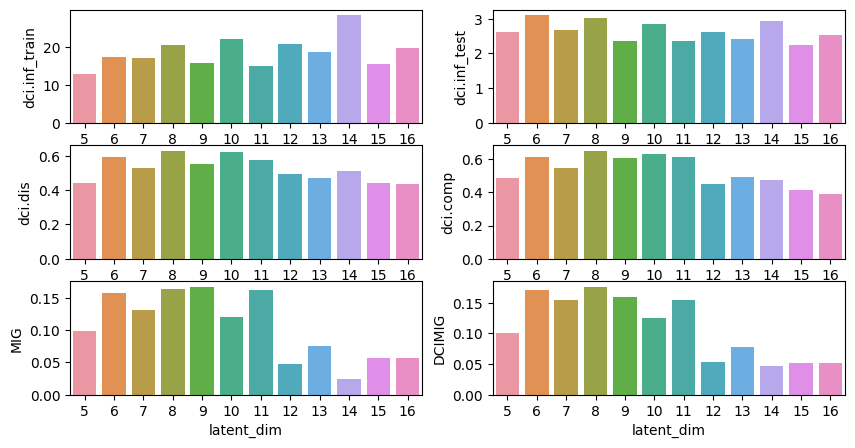

In [13]:
plot_perf()

Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.25it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.22it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.51it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.36it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.82it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.09it/s]


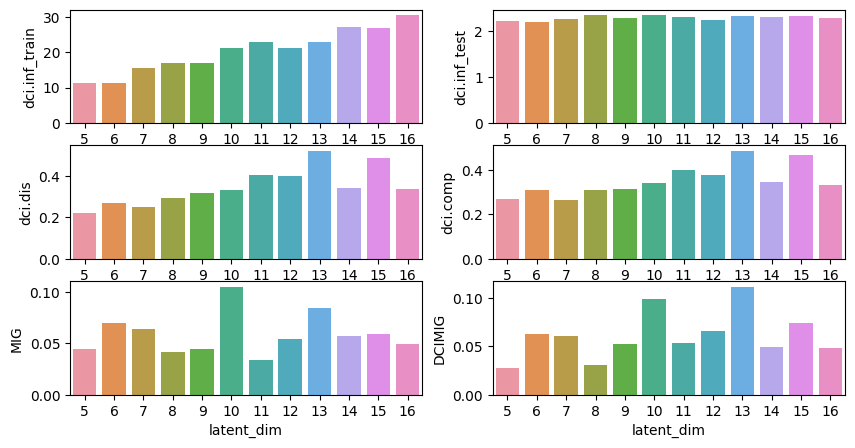

In [14]:
plot_perf("factor_dsprites")

Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.03it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.38it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.33it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.23it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.07it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.26it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


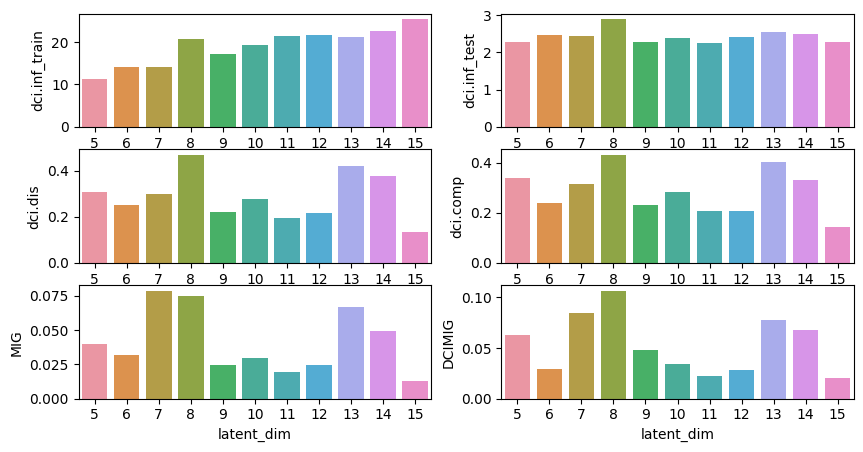

In [15]:
plot_perf("betaH_dsprites")

Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.28it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.21it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.03it/s]


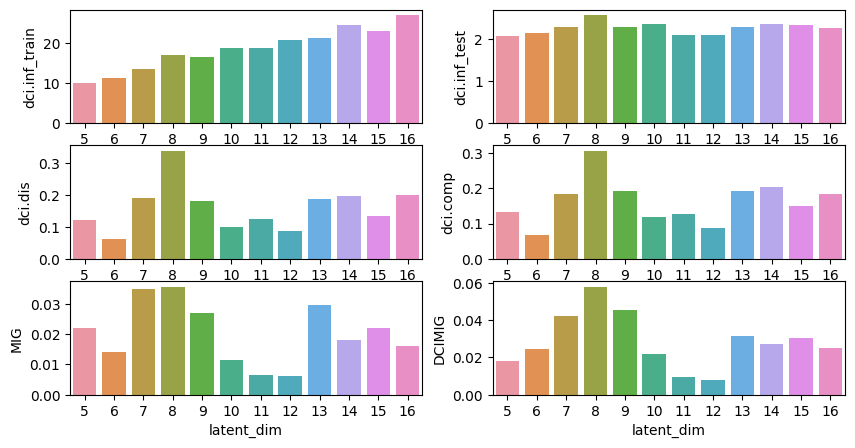

In [16]:
plot_perf("simpleVAE")

In [17]:
model_names=["BetaTC-VAE","Factor-VAE","BetaH-VAE","Simple-VAE"]
m=["btcvae_dsprites","factor_dsprites","betaH_dsprites","simpleVAE"]
n_codes=[8,13,8,8]
results=[]
models=[m for m in model_names for i in range(6)]
for n,model_name in enumerate(m):
        model = load_model_w_name(n_codes[n],device,model_name=model_name) 
        results.append(evaluate_metrics(ds,model,rate=1))
columns = [k for k,v in results[0].items() if k!="importance_matrix"]
values = [[v for k,v in d.items() if k!="importance_matrix"] for d in results]
df = pd.DataFrame(values, columns=columns)
df['model_name'] = model_names
df

Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Computing DCI metric with latent codes


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.04it/s]


MIG  dci.inf_train  dci.inf_test   dci.dis  dci.comp    DCIMIG  \
0  0.166333      18.584070      3.075876  0.626088  0.647161  0.177291   
1  0.082391      20.454711      2.208065  0.516977  0.482850  0.106937   
2  0.075630      19.355497      3.109977  0.450353  0.417965  0.108110   
3  0.036947      16.099955      2.519899  0.342741  0.308016  0.057400   

   model_name  
0  BetaTC-VAE  
1  Factor-VAE  
2   BetaH-VAE  
3  Simple-VAE

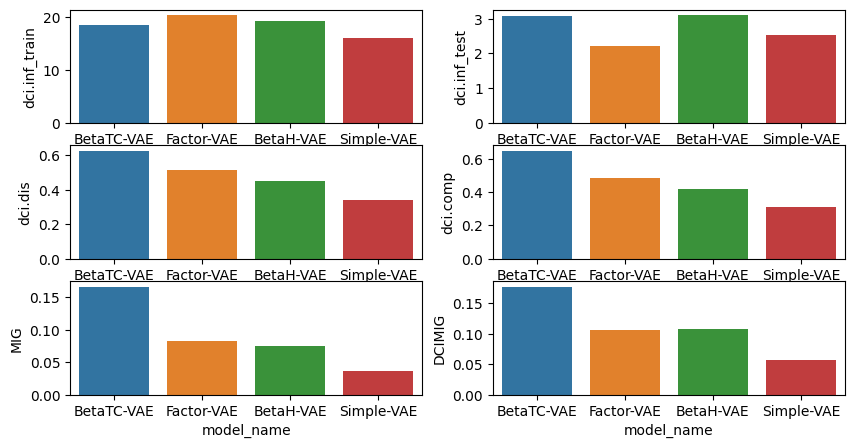

In [18]:
f, ax = plt.subplots(3, 2,figsize=(10, 5))

sns.barplot(data=df, x='model_name',y='dci.inf_train',ax=ax[0,0])
sns.barplot(data=df, x='model_name',y='dci.inf_test',ax=ax[0,1])
sns.barplot(data=df, x='model_name',y='dci.dis',ax=ax[1,0])
sns.barplot(data=df, x='model_name',y='dci.comp',ax=ax[1,1])
sns.barplot(data=df, x='model_name',y='MIG',ax=ax[2,0])
sns.barplot(data=df, x='model_name',y='DCIMIG',ax=ax[2,1])
plt.savefig("vae_performance.png")
plt.show()